In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
from torch.utils.data import DataLoader
from DataLoader import AfricanWildlifeDataset, show_image, show_pair
from DenoisingAE import DenoisingAE
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

33

In [3]:
# from pathlib import Path
# import os

# y = None
# with open(f"{Path.home()}/.config/Ultralytics/settings.yaml") as stream:
#     this_path = os.path.join(os.getcwd(), "aaa")
#     try:
#         y = yaml.safe_load(stream)
#         print(y)
#         y["datasets_dir"] = this_path
#         print(y)
#         # yaml.safe_dump(y, stream)
#     except yaml.YAMLError as exc:
#         print(exc)

# with open(f"{Path.home()}/.config/Ultralytics/settings.yaml", "w") as f:
#     yaml.dump(y, f)

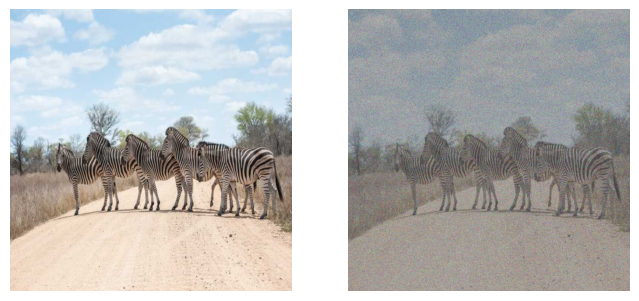

Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2))
Conv2d(6, 12, kernel_size=(4, 4), stride=(2, 2))
Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2))

ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2))
ConvTranspose2d(12, 6, kernel_size=(4, 4), stride=(2, 2))
ConvTranspose2d(6, 3, kernel_size=(4, 4), stride=(2, 2))



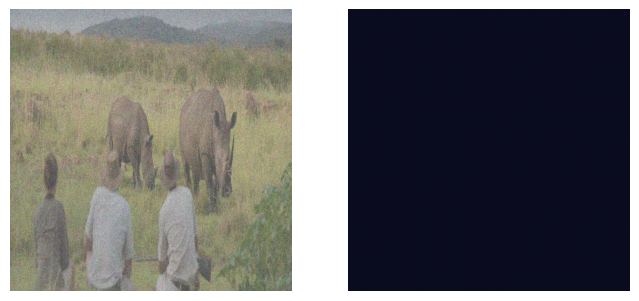

In [4]:
import gin

gin.parse_config_file("config.cfg")

train_dataset = AfricanWildlifeDataset()
val_dataset = AfricanWildlifeDataset(kind="valid")

show_image(train_dataset)

# add_wandb_callback(model, enable_model_checkpointing=True)
# results = model.train(
#     data="african_wildlife.yaml",
#     epochs=20,
#     imgsz=640,
#     # project="aiproject",
# )

# print(results)

img, label = train_dataset[1000]
ae = DenoisingAE()
decoded = ae(img)

show_pair(img, decoded)

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, num_workers=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=8)

In [6]:
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="denoising_autoencoder")

trainer = Trainer(logger=logger, max_epochs=500)

trainer.fit(model=ae, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/edoardo/anaconda3/envs/aiproject/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/home/edoardo/anaconda3/envs/aiproject/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-06-06 16:35:57.959577: I tensorflow/core/util/port.c

Training: |          | 0/? [00:00<?, ?it/s]

/home/edoardo/anaconda3/envs/aiproject/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/edoardo/anaconda3/envs/aiproject/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/edoardo/anaconda3/envs/aiproject/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
